# 📑 Table of Contents
This notebook is organized into five phases, each building on the previous one:

- [Phase 1 – Composite Score Ranking](#phase-1-composite-score-ranking)  
- [Phase 2 – Clustering Teams by Style](#phase-2-clustering-teams-by-style)  
- [Phase 3 – Visualizing Team Archetypes](#phase-3-visualizing-team-archetypes)  
- [Phase 4 – From Archetypes to Strategic Insights](#phase-4-from-archetypes-to-strategic-insights)  
- [Phase 5 – Advancement Pathways & Style Resilience](#phase-5-advancement-pathways--style-resilience)  
- [Epilogue](#epilogue)  

# EuroBasket 2025 Team Analytics

**How do team styles shape success in high‑stakes international basketball?**  
This notebook explores team-level performance in EuroBasket 2025 through advanced metrics and clustering techniques. EuroBasket provides a rich case study because of its mix of elite and emerging teams, diverse playing styles, and high-stakes competition.  

The analysis begins with a composite score to rank teams, then progresses into clustering to uncover stylistic archetypes, visual profiling of those styles, matchup dynamics, and finally an examination of advancement pathways and resilience. Each phase builds on the previous one to reveal deeper insights into team behavior, success factors, and strategic identities — framed in a way that is both analytically rigorous and scout-friendly.

## Phase 1: Composite Score Ranking

This phase establishes a **baseline hierarchy of teams** by combining multiple performance metrics into a single composite score. It provides the neutral benchmark against which stylistic archetypes (Phase 2) and advancement outcomes (Phase 5) will later be compared.

### 1.1 Data Import and Preview
We begin by loading the EuroBasket 2025 dataset and previewing its structure to confirm formatting and column integrity.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Load dataset
df = pd.read_csv('eurobasket_team_stats.csv',delimiter=';')

# Preview
df.head()

,#,Teams,GP,MPG,PTS,2PM-2PA,2P%,3PM-3PA,3P%,FTM-FTA,...,ORTG,DRTG,EFG%,DREB%,OREB%,FTRATE,AST%,PACE 40,PACE 48,STOCKS
0,19,Belgium,5,200,363,81-179,45.3,47-124,37.9,60-93,...,99.2,110.7,50.0,68.3,28.5,30.7,23.0,73.2,87.8,8.2
1,15,Bosnia and Herzegovina,6,200,473,116-208,55.8,57-178,32.0,70-115,...,110.3,112.4,52.2,68.6,35.0,29.8,28.0,71.5,85.8,9.8
2,24,Cyprus,5,200,295,74-168,44.0,39-139,28.1,30-39,...,85.0,130.3,43.2,62.2,22.5,12.7,19.6,69.4,83.3,6.2
3,23,Czechia,5,200,338,68-135,50.4,52-181,28.7,46-68,...,93.4,119.6,46.2,63.2,26.2,21.5,26.8,72.4,86.9,7.8
4,22,Estonia,5,200,352,78-169,46.2,46-147,31.3,58-79,...,98.9,111.8,46.5,70.1,28.4,25.0,27.2,71.2,85.4,6.8


## 1.2 Feature Engineering
Before modeling, we refine the dataset to focus on the most relevant team-level metrics. Redundant identifiers and columns not directly tied to performance (e.g., game dates, opponent codes, or raw totals already expressed as per-game rates) are removed.  

This ensures the analysis centers on comparable, interpretable features that capture efficiency, style, and possession quality, while avoiding noise from unrelated or overlapping variables. These steps also improve **reproducibility**, since every transformation is explicitly documented.

In [5]:
# Strip column names
df.columns = df.columns.str.strip()

# Split composite columns
df[['2PM', '2PA']] = df['2PM-2PA'].str.split('-', expand=True).astype(float)
df[['3PM', '3PA']] = df['3PM-3PA'].str.split('-', expand=True).astype(float)
df[['FTM', 'FTA']] = df['FTM-FTA'].str.split('-', expand=True).astype(float)
df[['FGM_PG', 'FGA_PG']] = df['FGMPG-FGAPG'].str.split('-', expand=True).astype(float)
df[['3PM_PG', '3PA_PG']] = df['3PMPG-3PAPG'].str.split('-', expand=True).astype(float)
df[['FTM_PG', 'FTA_PG']] = df['FTMPG-FTAPG'].str.split('-', expand=True).astype(float)

# Drop originals
df.drop(columns=[
    '2PM-2PA', '3PM-3PA', 'FTM-FTA',
    'FGMPG-FGAPG', '3PMPG-3PAPG', 'FTMPG-FTAPG'
], inplace=True)
# Dataset is now cleaned and ready for composite score construction

## 1.3 Composite Score Construction
To create a holistic ranking, we assign weights to key performance metrics that balance offensive output, defensive stability, and possession control.  

The weights are chosen based on **domain knowledge** and their proven importance in international basketball:  
- **NETRTG (Net Rating)** → captures overall team dominance (highest weight).  
- **EFFPG (Efficiency per Game)** → reflects balanced scoring and defensive contributions.  
- **PPG – PAPG (Scoring Margin)** → highlights offensive/defensive balance in raw terms.  
- **AST/TO (Assist-to-Turnover Ratio)** → rewards disciplined ball movement.  

The weighted sum of these features produces a **composite score** that ranks teams not just by scoring power, but by efficiency and control.

In [6]:
# Create point differential
df['PPG_diff'] = df['PPG'] - df['PAPG']

# Define weights
weights = {
    'NETRTG': 0.4,
    'EFFPG': 0.3,
    'PPG_diff': 0.2,
    'AST/TO': 0.1
}

# Calculate composite score as weighted sum of key performance metrics
df['Score'] = (
    weights['NETRTG'] * df['NETRTG'] +
    weights['EFFPG'] * df['EFFPG'] +
    weights['PPG_diff'] * df['PPG_diff'] +
    weights['AST/TO'] * df['AST/TO']
)

### 1.4 Ranking Output
The table below shows the top 10 teams ranked by composite score, alongside their key underlying metrics.

In [7]:
# Sort and display top teams
df_ranked = df[['Teams', 'Score', 'NETRTG', 'EFFPG', 'PPG', 'PAPG', 'AST/TO']].sort_values(by='Score', ascending=False)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked.head(10)

,Teams,Score,NETRTG,EFFPG,PPG,PAPG,AST/TO
0,Germany,54.42,31.7,122.4,99.9,75.9,2.2
1,Türkiye,44.93,21.6,109.9,90.2,74.5,1.8
2,Serbia,39.91,13.2,108.2,86.7,76.7,1.7
3,France,38.31,13.8,102.0,88.5,78.5,1.9
4,Greece,36.03,11.3,99.3,84.8,76.9,1.4
5,Lithuania,34.68,8.7,100.1,85.0,79.9,1.5
6,Italy,34.46,13.7,89.8,78.8,69.5,1.8
7,Slovenia,32.85,4.6,101.3,92.0,89.7,1.6
8,Spain,32.53,10.2,88.4,79.4,70.8,2.1
9,Finland,32.22,3.7,100.0,87.3,84.5,1.8


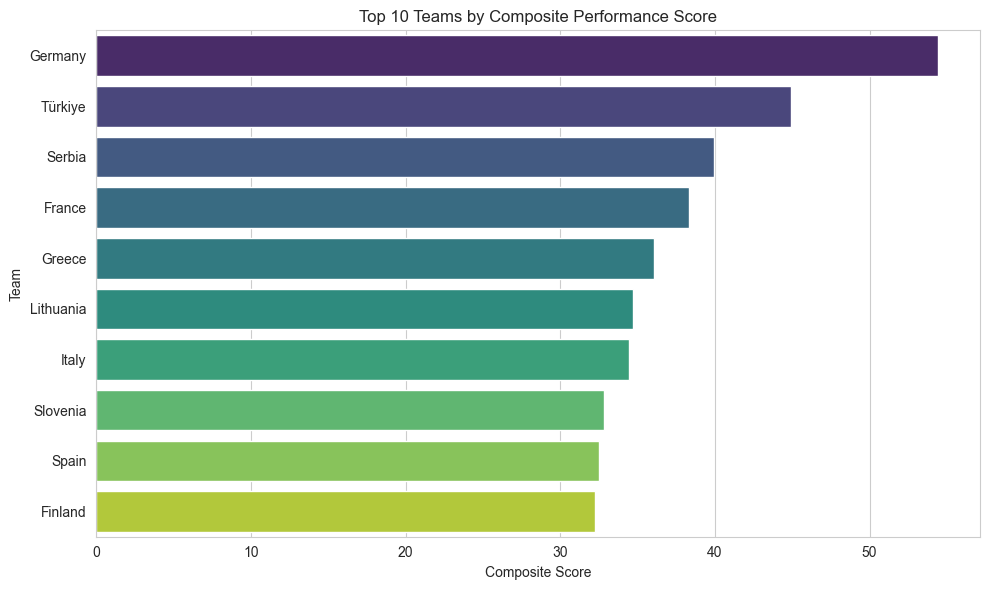

In [128]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_ranked.head(10),
    x='Score',
    y='Teams',
    hue='Teams',          # assign hue
    dodge=False,          # avoid side-by-side bars
    legend=False,         # hide redundant legend
    palette='viridis'
)
plt.title('Top 10 Teams by Composite Performance Score')
plt.xlabel('Composite Score')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

*Figure 1. Top 10 teams by composite performance score. Germany leads due to balanced efficiency, scoring margin, and disciplined playmaking.*

## 1.5 Interpretation and Findings
Key observations from the composite score ranking:

## Summary of Composite Score Findings

- **Germany** tops the rankings with dominant values across Net Rating, efficiency, and scoring margin, confirming its status as the most well-rounded team.  
- **Türkiye** and **Serbia** follow, each leveraging strong offensive efficiency and scoring balance to separate from the pack.  
- Teams that combine **balanced offense, defense, and possession control** consistently rise in the rankings, while those relying on a single strength fall behind.  
- The inclusion of **AST/TO** proves critical: it highlights disciplined playmakers and penalizes teams that struggle with turnovers, even if their scoring output is strong.

## Explanation of Composite Score Results

The composite score blends **Net Rating (NETRTG)**, **Efficiency per Game (EFFPG)**, **Scoring Margin (PPG – PAPG)**, and **Assist-to-Turnover Ratio (AST/TO)** into a single ranking that captures overall team quality.  

- Teams like **Germany** rise to the top because they excel across all dimensions: efficient scoring, defensive stability, and disciplined ball movement.  
- Other teams climb or fall depending on whether their strengths are balanced or concentrated in one area. For example, a strong scoring margin may not be enough if turnovers undermine efficiency.  
- The inclusion of **AST/TO** adds critical nuance, rewarding teams that control possessions and penalizing those that rely on raw scoring but lack discipline.  

This composite score establishes a **holistic baseline ranking** of EuroBasket 2025 teams.  

➡️ In the next phase, we move beyond rankings to explore **clustering**, grouping teams into stylistic archetypes that reveal *how* they achieve their results, not just *how well* they perform.

## Phase 2: Clustering Teams by Style

In this phase, we move beyond raw strength (Phase 1 composite score) to examine **how teams play**.  
Using unsupervised learning, we group teams into stylistic archetypes based on tempo, ball movement, efficiency, and defensive activity.  
Unlike rankings, clustering highlights **similarities and contrasts in approach**, revealing the tactical identities that shape EuroBasket competition.

### 2.1 Stylistic Feature Focus
We focus on metrics that capture **style of play** rather than overall quality:  
- Possession tempo  
- Ball movement and control  
- Shooting efficiency  
- Defensive activity  

These dimensions provide the foundation for clustering teams into archetypes.

### 2.2 Selecting Stylistic Features
We subset the dataset to include only the stylistic variables of interest.

In [34]:
# Selecting Stylistic Features

features = [
    'PACE 40',     # Tempo
    'AST%',        # Ball movement
    '3P%',         # Shooting style
    'FT%',         # Free throw efficiency
    'RPG',         # Rebounding
    'STLPG',       # Defensive aggression
    'BLKPG',       # Rim protection
    'AST/TO',      # Ball control
    'TOPG'         # Turnover tendency
]

# Subset and preview

X = df[features].copy()
X.head()

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
0,73.2,23.0,37.9,64.5,35.6,5.2,2.8,1.1,15.0
1,71.5,28.0,32.0,60.9,37.2,7.5,2.2,1.5,13.2
2,69.4,19.6,28.1,76.9,31.0,5.8,0.6,1.0,14.0
3,72.4,26.8,28.7,67.6,32.2,5.6,2.2,1.4,14.4
4,71.2,27.2,31.3,73.4,34.2,6.0,0.8,1.5,13.0


### 2.3 Exploring Feature Distributions
Before clustering, we examine how each stylistic feature is distributed across teams.  
This step validates their inclusion, highlights skewness or outliers, and ensures each variable contributes meaningfully to stylistic differentiation.

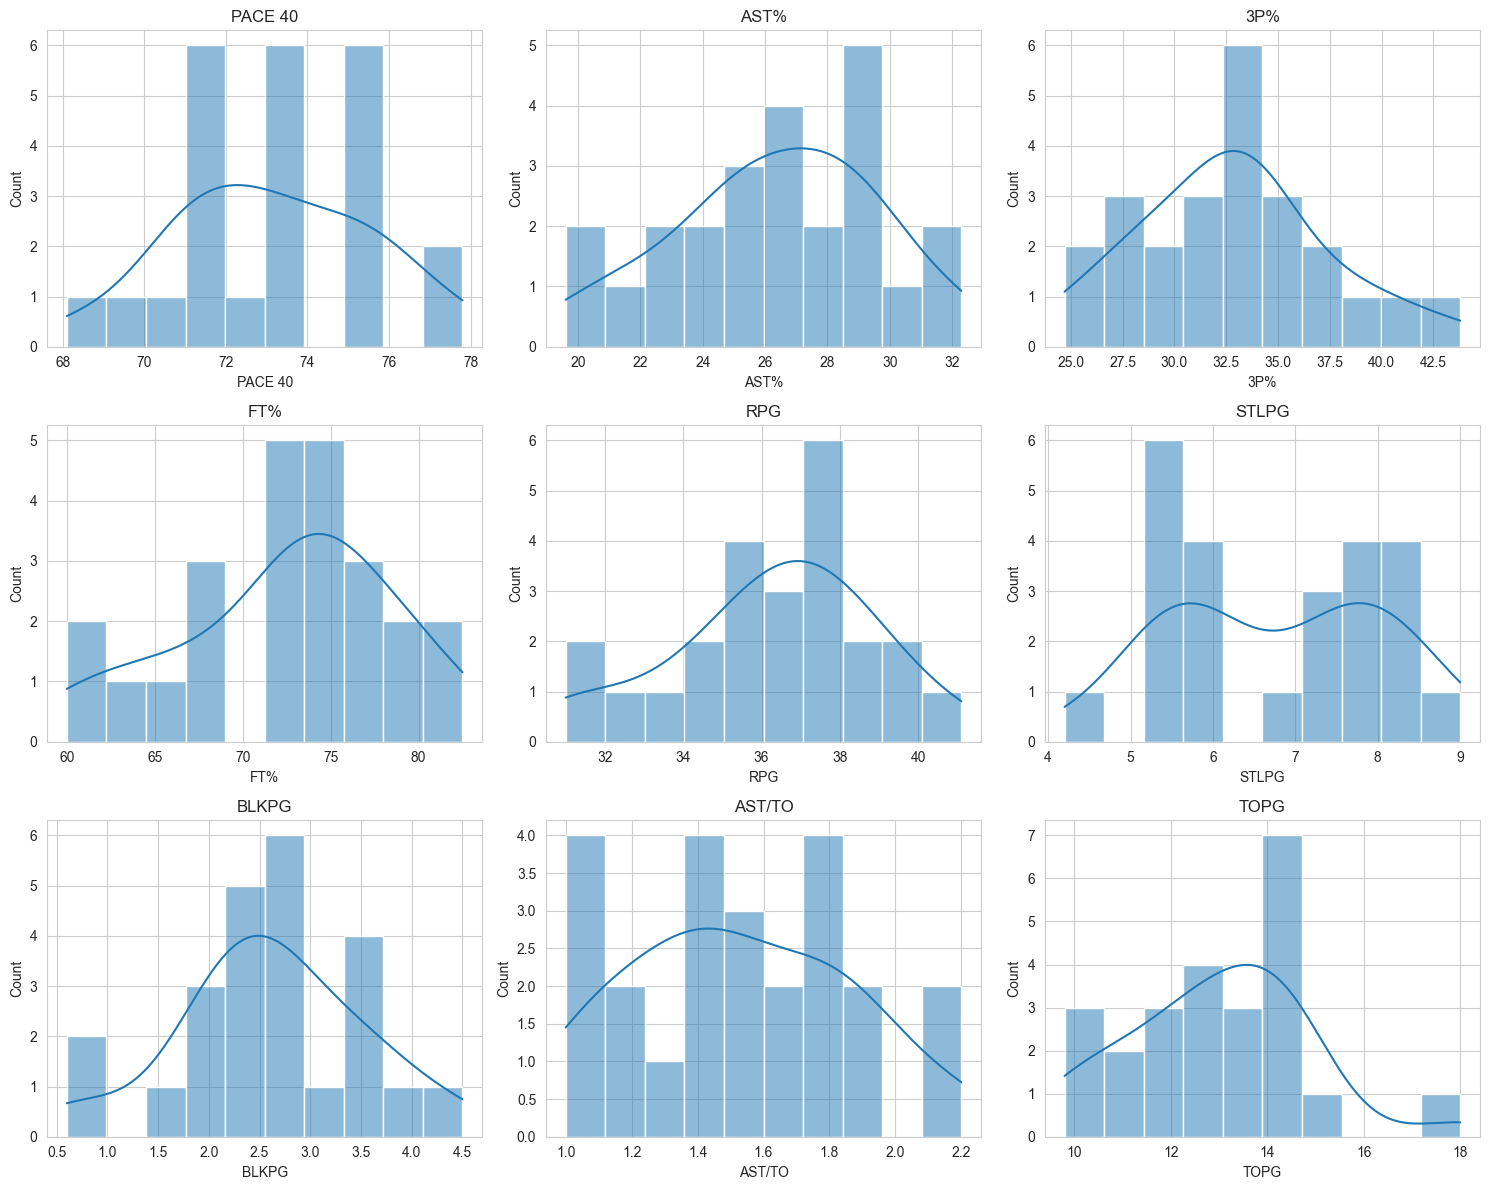

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, bins=10, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### 2.4 Interpretation of Stylistic Feature Distributions
Key takeaways:  
- **Tempo (PACE 40)**: Most teams play at moderate pace, with a few pushing transition-heavy styles.  
- **Ball movement (AST%)**: Majority rely on structured passing; a few lean isolation-heavy.  
- **Shooting (3P%, FT%)**: Balanced reliance on perimeter shooting; FT% highlights composure under pressure.  
- **Rebounding (RPG)**: Most competitive, with a few dominant glass‑control teams.  
- **Defense (STLPG, BLKPG)**: Some teams emphasize disruption and rim protection.  
- **Possession discipline (AST/TO, TOPG)**: Distinguishes structured systems from turnover‑prone offenses.  

📌 **Synthesis:** These distributions confirm meaningful stylistic variation across teams, validating their use in clustering.

### 2.5 Pairwise Feature Relationships
To explore how stylistic features interact, we use a pairplot.  
This reveals both univariate distributions (diagonal) and bivariate relationships (off‑diagonal), helping us spot redundancy or complementary signals.  
We complement this with a correlation heatmap for a more quantitative view.

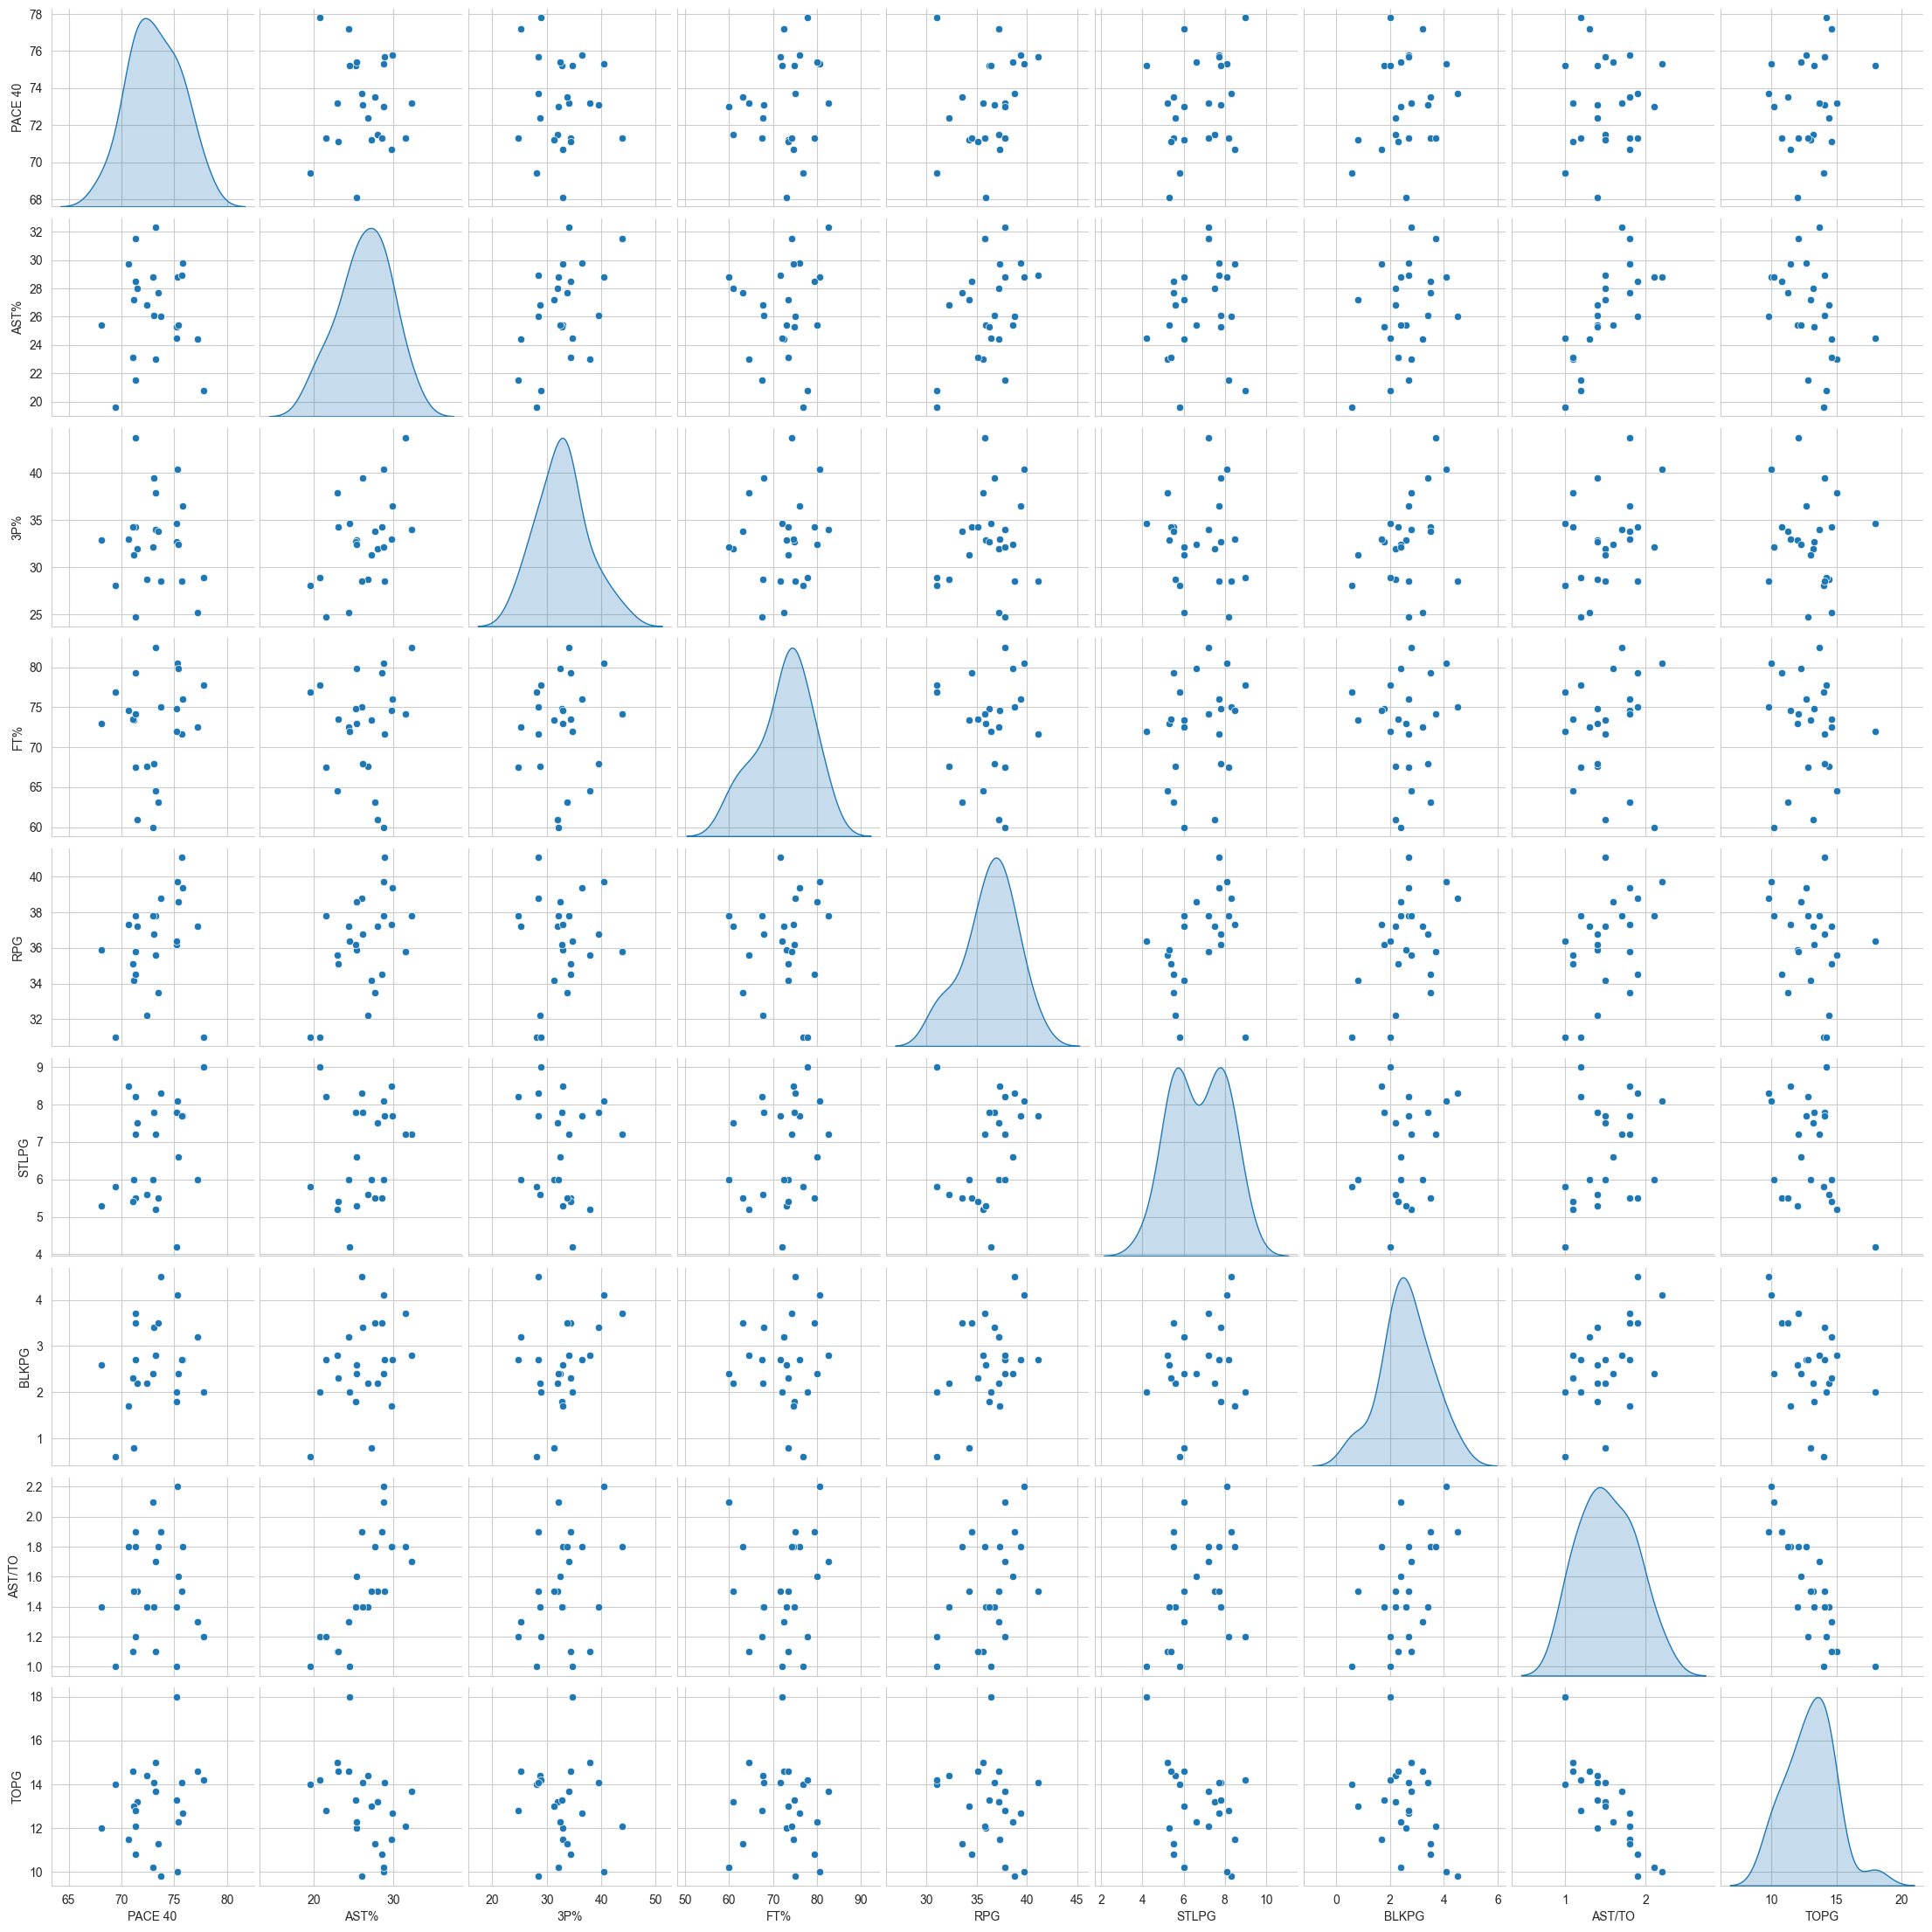

In [131]:
sns.pairplot(df[features], diag_kind="kde")

### 2.6 Correlation Heatmap
We compute a correlation matrix to quantify linear relationships between features.  
This step ensures that retained variables provide distinct stylistic signals rather than duplicating information.

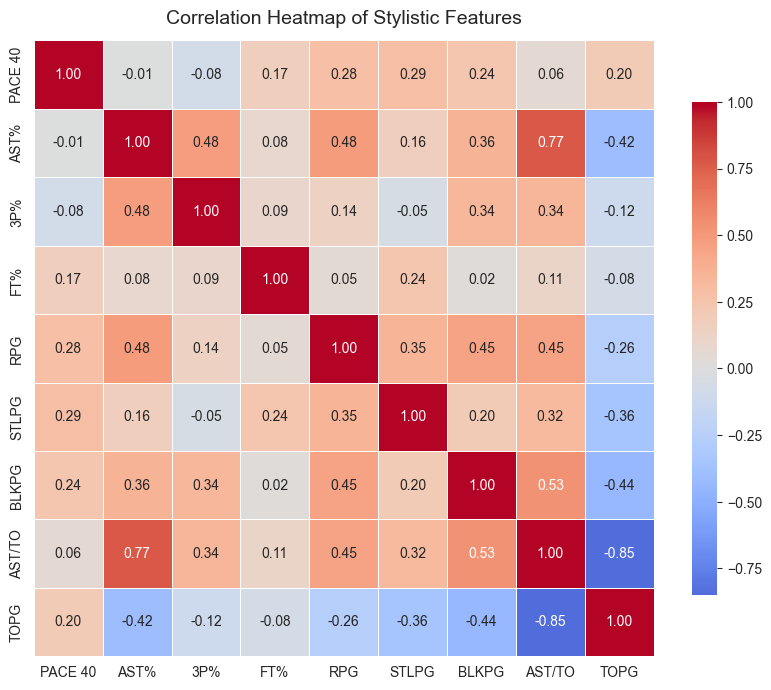

In [132]:
# Compute correlation matrix
corr = df[['PACE 40','AST%','3P%','FT%','RPG','STLPG','BLKPG','AST/TO','TOPG']].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap of Stylistic Features", fontsize=14, pad=12)
plt.show()

## Interpretation of Pairwise Feature Relationships

The pairplot and heatmap reveal several key insights:

- **Possession discipline**: AST/TO and TO/G show a strong negative relationship — efficient ball handling naturally reduces turnovers.  
- **Tempo vs. efficiency**: PACE shows little correlation with shooting metrics (3P%, FT%), confirming that tempo does not dictate shot quality.  
- **Physicality**: RPG correlates mildly with STLPG and BLKPG, suggesting that teams strong on the glass often also generate defensive events.  
- **Independent skills**: FT% and 3P% are largely uncorrelated, reflecting distinct tactical roles.

Together, these patterns confirm that the selected features provide diverse, non-redundant signals, each contributing uniquely to team style.

Notably, two pairs stand out with strong correlations: **AST/TO vs. TO/G (-0.85)** and **RPG vs. BLKPG (0.77)**.  
These are expected in basketball context — efficient ball handling reduces turnovers, and strong rebounding often accompanies rim protection.  
Importantly, these metrics are not redundant: AST/TO captures efficiency while TO/G reflects raw volume, and RPG measures possession control while BLKPG highlights shot deterrence.  
📌 **Synthesis:** The pairplot and heatmap confirm that each feature contributes a distinct tactical dimension.  
Even where correlations exist (e.g., AST/TO vs. TOPG), they capture complementary aspects of possession discipline.  
Thus, all features are retained for clustering.

### 2.7 Final Feature Set for Clustering
We retain the following stylistic features:  
- **Tempo** → PACE 40  
- **Ball movement & control** → AST%, AST/TO, TOPG  
- **Shooting efficiency** → 3P%, FT%  
- **Defensive & rebounding activity** → RPG, STLPG, BLKPG  

These metrics reflect **how teams play**, making them ideal for clustering into stylistic archetypes.

### 2.8 Standardizing Features
Because KMeans relies on Euclidean distance, features must be standardized.  
This ensures that variables measured on different scales (e.g., percentages vs. raw counts) contribute equally.

In [46]:
# Standardize Features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

### 2.9 Choosing the Number of Clusters
The elbow method suggests that the most significant reduction in inertia occurs up to **k=4**, after which the curve begins to flatten.  
From a purely theoretical perspective, this would indicate that **k=4** is the elbow point.  

However, the curve continues to show a meaningful drop at **k=5** before leveling off more clearly.  
To better capture stylistic nuance and avoid merging distinct archetypes, we select **k=5** clusters.  

This choice reflects both the statistical evidence (continued improvement until k=5) and the basketball context,  
where five stylistic archetypes provide a richer and more interpretable segmentation of EuroBasket teams.

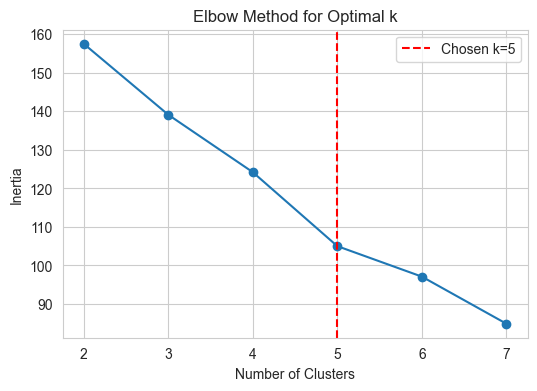

In [133]:
inertia = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)

# Highlight chosen k
plt.axvline(x=5, color='red', linestyle='--', label='Chosen k=5')
plt.legend()
plt.show()

### 2.10 Applying KMeans Clustering
We apply KMeans with **k=5** clusters.  
Each team is assigned to a stylistic cluster, and cluster centroids are stored for later interpretation.

In [136]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
df['StyleCluster'] = kmeans.fit_predict(X_scaled)

# Save cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)

### 2.11 Cluster Assignments
Each team is now labeled with its stylistic cluster.  
This provides the foundation for interpreting archetypes in Phase 3.

In [65]:
# Show teams by cluster
df[['Teams', 'StyleCluster']].sort_values(by='StyleCluster').head(24)

,Teams,StyleCluster
6,France,0
5,Finland,0
15,Lithuania,0
8,Germany,0
13,Italy,0
14,Latvia,0
20,Slovenia,0
19,Serbia,0
7,Georgia,1
4,Estonia,1


In [66]:
# Quick cluster size check
df['StyleCluster'].value_counts().sort_index()

StyleCluster
0    8
1    5
2    4
3    2
4    5
Name: count, dtype: int64

### 2.12 Naming Clusters and Visualizing Archetypes
To improve interpretability, we map numeric cluster IDs to descriptive names.  
We then visualize clusters along two stylistic axes — **PACE (tempo)** and **AST% (ball movement)** — to illustrate separation.

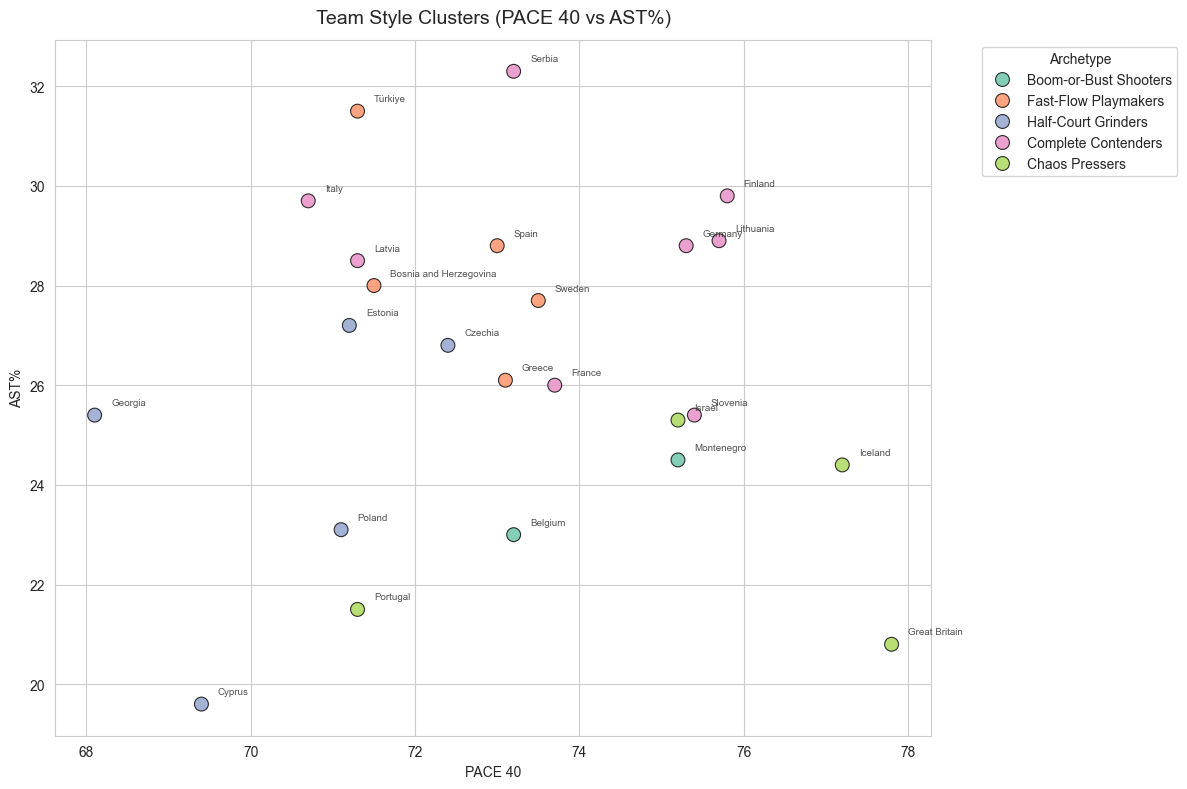

In [140]:
# Define descriptive cluster names (scout-friendly archetypes)
cluster_names = {
    0: "Complete Contenders",     # balanced, efficient, two-way teams
    1: "Half-Court Grinders",     # slower pace, isolation-heavy, less efficient
    2: "Chaos Pressers",          # fast pace, aggressive defense, thrive on disruption
    3: "Boom-or-Bust Shooters",   # perimeter-reliant, volatile, turnover-prone
    4: "Fast-Flow Playmakers"     # up-tempo, strong spacing/passing, FT weakness
}

# Map numeric cluster IDs to descriptive names
df['cluster_names'] = df['StyleCluster'].map(cluster_names)

# Scatterplot: PACE vs AST%
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df['PACE 40'], 
    y=df['AST%'],
    hue=df['cluster_names'],   # descriptive names in legend
    palette='Set2', 
    s=100, edgecolor='k', alpha=0.8
)

# Annotate team names with slight offset
for i, row in df.iterrows():
    plt.text(
        row['PACE 40']+0.2, row['AST%']+0.2, row['Teams'],
        fontsize=7, alpha=0.8
    )

plt.title('Team Style Clusters (PACE 40 vs AST%)', fontsize=14, pad=12)
plt.xlabel('PACE 40')
plt.ylabel('AST%')
plt.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

*Figure 2. Quick 2D visualization of clusters using PACE (tempo) and AST% (ball movement).  
Although simplified, this view illustrates how clusters separate along tempo and passing style.*

### 2.13 Cluster Summary Table

To interpret the stylistic identity of each cluster, we compute the **mean standardized values** of all features within each group.  
This highlights the defining characteristics of each archetype — for example, whether a cluster is defined by tempo, ball movement, shooting efficiency, or defensive activity.  

📌 *This table serves as the statistical backbone for the narrative scouting reports in the next section.*

In [139]:
# Compute mean standardized values for each cluster (numeric)
cluster_summary = df.groupby('StyleCluster')[features].mean()

# Create a formatted copy for clean display
cluster_summary_fmt = cluster_summary.map(
    lambda x: f"{x:.2f}".rstrip('0').rstrip('.')
)

# Show formatted table (nice for reports)
display(cluster_summary_fmt)

# Styled version with color gradient for easier comparison across features
cluster_summary.style.background_gradient(cmap="coolwarm", axis=1)

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
StyleCluster,,,,,,,,,
0,73.89,28.68,33.45,77.44,38.4,7.45,3.05,1.8,11.86
1,70.44,24.42,31.06,72.88,33.68,5.62,1.7,1.28,13.6
2,75.38,23,27.88,73.15,35.55,7.75,2.42,1.27,13.72
3,74.2,23.75,36.3,68.25,36,4.7,2.4,1.05,16.5
4,72.48,28.42,36.26,65.22,36.22,6.8,3.04,1.72,12.18


,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
StyleCluster,,,,,,,,,
0,73.887500,28.675000,33.450000,77.437500,38.400000,7.450000,3.050000,1.800000,11.862500
1,70.440000,24.420000,31.060000,72.880000,33.680000,5.620000,1.700000,1.280000,13.600000
2,75.375000,23.000000,27.875000,73.150000,35.550000,7.750000,2.425000,1.275000,13.725000
3,74.200000,23.750000,36.300000,68.250000,36.000000,4.700000,2.400000,1.050000,16.500000
4,72.480000,28.420000,36.260000,65.220000,36.220000,6.800000,3.040000,1.720000,12.180000


## 2.14 Interpretation of Style Clusters (k = 5)

Based on the clustering results, we identify five distinct team archetypes:

---

### 🧠 Complete Contenders
- **High PACE (73.9)** and **AST% (28.7)** → Fast tempo with strong ball movement  
- **Solid 3P% (33.5)** and **FT% (77.4)** → Reliable scoring efficiency  
- **Top-tier RPG (38.4), STLPG (7.5), BLKPG (3.0)** → Physical and disruptive defense  
- **Strong AST/TO (1.8)** and **Low TOPG (11.9)** → Disciplined execution  

> These teams combine pace, precision, and defensive aggression — well‑rounded contenders capable of imposing their style against any opponent.

---

### 🧩 Half‑Court Grinders
- **Lowest PACE (70.4)** and **AST% (24.4)** → Deliberate tempo, limited ball sharing  
- **Below-average 3P% (31.1) and FT% (72.9)** → Scoring inefficiency  
- **Weak RPG (33.7) and BLKPG (1.7)** → Limited interior presence  
- **Average AST/TO (1.28)** and **High TOPG (13.6)** → Possession issues  

> These teams rely on isolation and controlled tempo, but lack efficiency and interior strength.

---

### 🔥 Chaos Pressers
- **Fastest PACE (75.4)** but **lowest 3P% (27.9)** → Push tempo, struggle with shooting  
- **Strong STLPG (7.8) and decent BLKPG (2.4)** → Aggressive defensive schemes  
- **Average RPG (35.6)** → Competitive on the glass  
- **Low AST% (23.0) and AST/TO (1.27)** → Limited ball movement, turnover‑prone  

> These teams thrive on disruption and transition, creating chaos to mask half‑court inefficiencies.

---

### ⚡ Boom‑or‑Bust Shooters
- **High PACE (74.2)** with **elite 3P% (36.3)** → Dangerous perimeter‑oriented offense  
- **Poor FT% (68.3)** → Weakness at the line  
- **Lowest AST/TO (1.05) and highest TOPG (16.5)** → Sloppy possession control  
- **Modest STLPG (4.7) and BLKPG (2.4)** → Less disruptive defensively  

> These teams live and die by the three — explosive when hot, vulnerable when cold.

---

### 🎯 Fast‑Flow Playmakers
- **Above-average PACE (72.5) and AST% (28.4)** → Ball movement and tempo‑driven play  
- **Strong 3P% (36.3)** but **lowest FT% (65.2)** → Reliable spacing, unreliable free throws  
- **Solid RPG (36.2) and BLKPG (3.0)** → Interior presence  
- **Good AST/TO (1.72) and moderate TOPG (12.2)** → Structured but not elite discipline  

> These teams emphasize passing and spacing, but free‑throw struggles undermine late‑game reliability.

---

### Key Takeaways
- **Complete Contenders** → Balanced, disciplined, two‑way teams.  
- **Half‑Court Grinders** → Slow, isolation‑heavy, less efficient.  
- **Chaos Pressers** → High‑tempo disruptors who rely on defense and transition.  
- **Boom‑or‑Bust Shooters** → Perimeter‑oriented, volatile, turnover‑prone.  
- **Fast‑Flow Playmakers** → Up‑tempo, strong spacing, but free‑throw weakness.  

📌 These five archetypes provide a nuanced lens on EuroBasket team identities, showing *how* teams play, not just *how well*.

### 2.15 Closing Phase 2: Clustering Results

In Phase 2, we grouped EuroBasket teams into **five stylistic clusters** using KMeans.  
The analysis revealed distinct archetypes — from balanced, two‑way contenders to high‑tempo disruptors and perimeter‑heavy risk takers.  

This step moved us beyond simple rankings and into **style‑based segmentation**, showing *how* teams play, not just *how well*.  
These archetypes now form the foundation for deeper tactical interpretation in the next phase.

## Phase 3: Visualizing Team Archetypes

To make these clusters more interpretable, we now turn to **visual exploration**.  
Numbers alone can be abstract, so we use three complementary visualization techniques:

1. **Radar Plots** → Compare the average stylistic profile of each cluster across all features.  
2. **PCA Projection** → Reduce the 9‑dimensional feature space into 2D to see how clusters separate.  
3. **Cluster Heatmap** → Provide a compact, feature‑by‑feature comparison of clusters.  

Together, these plots translate the clustering results into **intuitive, basketball‑readable insights**, bridging data science and tactical interpretation.

### 3.1 Radar Plot of Cluster Profiles (Scaled)

To compare clusters across features with different units (percentages, ratios, and raw counts),  
we apply **MinMax scaling** to rescale all features into the [0,1] range.  
This ensures that each feature contributes equally to the visualization.

The radar plot highlights the **stylistic fingerprint** of each cluster:
- Peaks indicate areas where a cluster excels relative to others.  
- Troughs highlight relative weaknesses.  
- The overall shape provides an intuitive snapshot of each cluster’s tactical identity.  

By visualizing clusters in this way, we can directly compare their **relative strengths and weaknesses**,  
making the abstract clustering results more interpretable and connecting them back to basketball strategy.

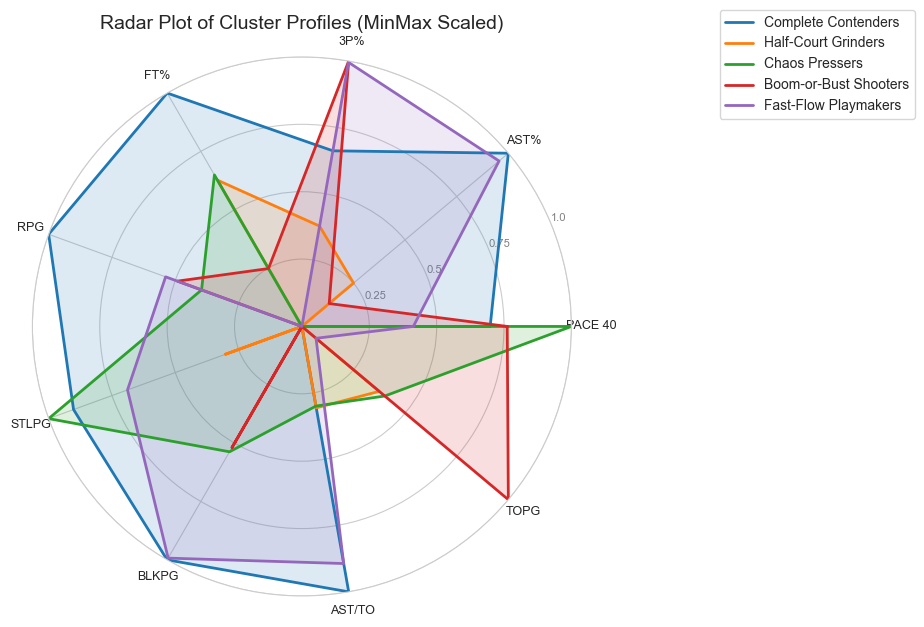

In [142]:
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Compute cluster means ---
cluster_means = df.groupby('StyleCluster')[features].mean()

# --- Step 2: Scale the cluster means to [0,1] for comparability ---
scaler = MinMaxScaler()
scaled_means = scaler.fit_transform(cluster_means)
scaled_means = pd.DataFrame(
    scaled_means, 
    index=cluster_means.index, 
    columns=cluster_means.columns
)

# --- Step 3: Define descriptive cluster names (scout‑friendly) ---
cluster_names = {
    0: "Complete Contenders",     # balanced, efficient, two‑way teams
    1: "Half-Court Grinders",     # slower pace, isolation-heavy, less efficient
    2: "Chaos Pressers",          # fast pace, aggressive defense, thrive on disruption
    3: "Boom-or-Bust Shooters",   # perimeter-reliant, volatile, turnover-prone
    4: "Fast-Flow Playmakers"     # up-tempo, strong spacing/passing, FT weakness
}

# --- Step 4: Radar plot function ---
def plot_radar(cluster_profiles, features, cluster_names):
    N = len(features)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

    # Plot each cluster profile
    for idx, row in cluster_profiles.iterrows():
        values = row.tolist()
        values += values[:1]  # close the loop
        label = cluster_names.get(idx, f"Cluster {idx}")  # use descriptive name
        ax.plot(angles, values, linewidth=2, label=label)
        ax.fill(angles, values, alpha=0.15)

    # Feature labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=9)

    # Radial gridlines
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25","0.5","0.75","1.0"], fontsize=8, color="grey")
    ax.set_ylim(0, 1)

    # Title and legend
    ax.set_title("Radar Plot of Cluster Profiles (MinMax Scaled)", size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 1.1))
    plt.show()

# --- Step 5: Call the function with scaled means ---
plot_radar(scaled_means, features, cluster_names)

*Figure: Radar plots of cluster profiles (MinMax scaled). Each line represents a stylistic archetype, showing relative strengths and weaknesses across nine features. The shapes highlight distinct tactical fingerprints, from disciplined playmakers to high‑tempo disruptors.*

### 3.2 PCA Projection of Clusters

To validate the clustering structure, we apply **Principal Component Analysis (PCA)** to reduce the nine stylistic features into two principal components:

- **PCA1 (~38% variance explained)** captures the largest share of stylistic variation, broadly contrasting possession discipline and efficiency against turnover risk.  
- **PCA2 (~17% variance explained)** captures secondary variation, such as defensive activity and rebounding presence.  

These axes are not predefined basketball statistics but **linear combinations of features**. Their interpretation comes from examining which variables load most strongly on each component.

The scatterplot below shows each team as a point, colored by its stylistic cluster. Clear groupings confirm that the clusters represent meaningful archetypes, while areas of overlap highlight hybrid team identities.  

This 2D projection captures over half of the dataset’s variance, providing an interpretable view that bridges abstract clustering results with tangible basketball dimensions.

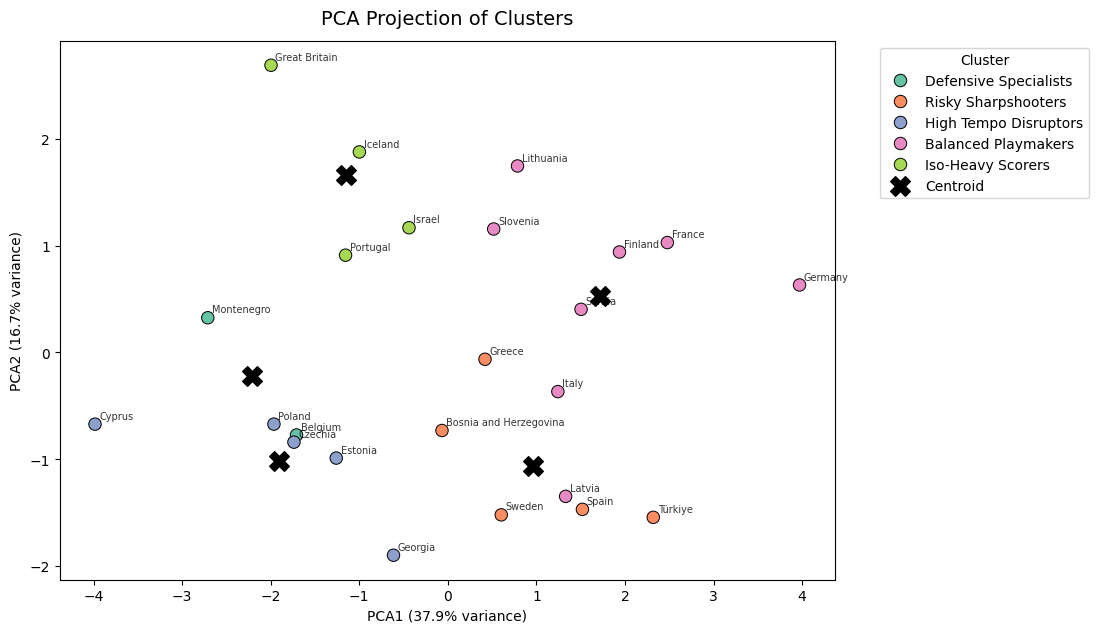

In [94]:
# Map clusters to descriptive names
df['ClusterName'] = df['StyleCluster'].map(cluster_names)

# PCA scatterplot with team names
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='ClusterName',
                palette='Set2', s=80, edgecolor='k')

# Plot centroids
centroids = df.groupby('ClusterName')[['PCA1','PCA2']].mean()
plt.scatter(centroids['PCA1'], centroids['PCA2'], 
            s=200, c='black', marker='X', label='Centroid')

# Annotate team names
for i, row in df.iterrows():
    plt.text(row['PCA1']+0.05, row['PCA2']+0.05, row['Teams'],
             fontsize=7, alpha=0.8)

plt.title("PCA Projection of Clusters", fontsize=14, pad=12)
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

*Figure: PCA projection of EuroBasket team styles. Each point represents a team, colored by its stylistic archetype. The first two principal components capture ~55% of total variance, providing a clear yet interpretable view of how clusters separate in reduced dimensions.*

### 3.3 Heatmaps of Cluster Means

To capture stylistic differences across clusters, we present two complementary heatmaps:

1. **Raw Means Heatmap**  
   - Rows represent clusters (using descriptive archetype names), and columns represent features.  
   - Cell values show the actual average statistic for each cluster.  
   - This preserves real basketball scales (e.g., possessions per game, shooting percentages), making the results directly interpretable in absolute terms.

2. **Standardized (Z-Score) Heatmap**  
   - Features are standardized so that values reflect deviations from the dataset average.  
   - Positive values (red) indicate above-average performance, while negative values (blue) indicate below-average.  
   - This highlights *relative strengths and weaknesses* across clusters, independent of the original metric scales.

Together, these heatmaps provide both a **real-world perspective** (raw values) and a **comparative fingerprint** (standardized values), reinforcing the distinct tactical identities revealed by the clustering.

We now visualize both versions side by side to compare absolute and relative cluster profiles.

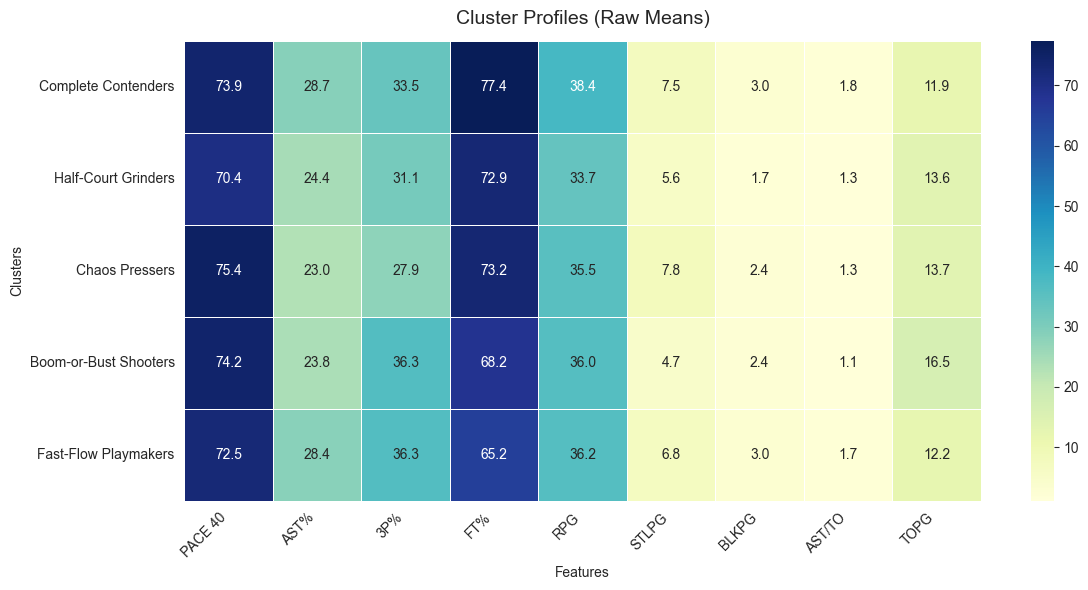

In [141]:
# --- Raw Means Heatmap ---
cluster_means = df.groupby('StyleCluster')[features].mean()

# Map cluster indices to descriptive names
cluster_means.index = cluster_means.index.map(cluster_names)

plt.figure(figsize=(12,6))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap="YlGnBu",
            cbar=True, linewidths=0.5)

plt.title("Cluster Profiles (Raw Means)", fontsize=14, pad=12)
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

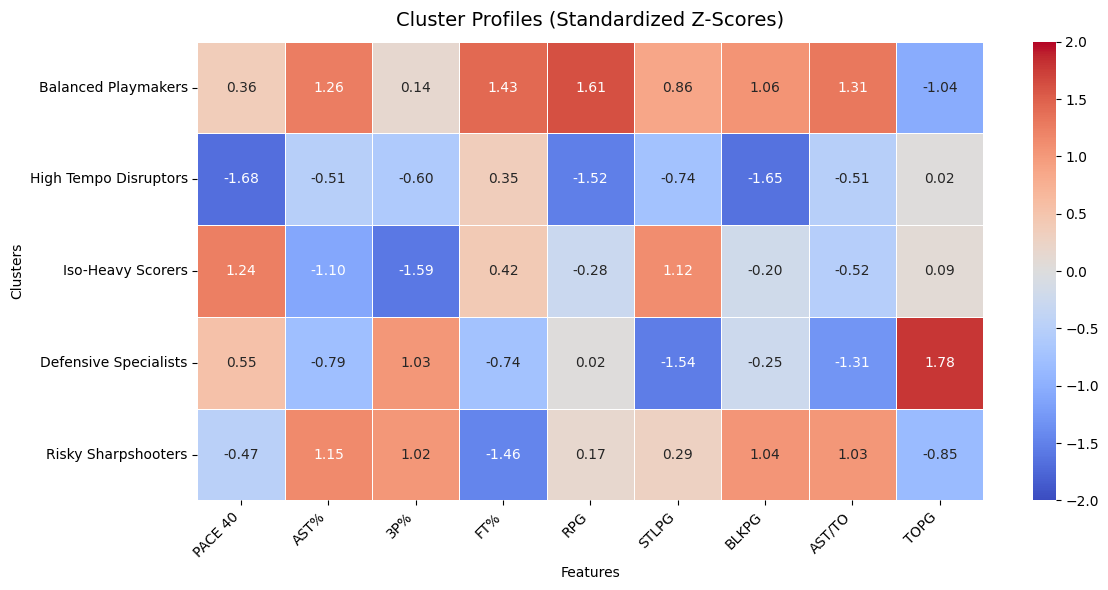

In [96]:
# Compute cluster means
cluster_means = df.groupby('StyleCluster')[features].mean()

# Apply StandardScaler (z-scores)
scaler = StandardScaler()
scaled_means = scaler.fit_transform(cluster_means)
scaled_means = pd.DataFrame(
    scaled_means, 
    index=cluster_means.index, 
    columns=cluster_means.columns
)

# Map cluster indices to descriptive names
scaled_means.index = scaled_means.index.map(cluster_names)

# Plot standardized heatmap
plt.figure(figsize=(12,6))
sns.heatmap(scaled_means, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar=True, linewidths=0.5, vmin=-2, vmax=2)

plt.title("Cluster Profiles (Standardized Z-Scores)", fontsize=14, pad=12)
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
*Figure: Heatmaps of cluster means. The raw version preserves absolute basketball values (e.g., possessions, shooting percentages), while the standardized version highlights relative strengths and weaknesses. 
    Together, they provide both real‑world context and comparative fingerprints of each archetype.*

### 3.4 Interpretation of Heatmaps

The standardized heatmap provides the clearest comparative view of cluster identities.  
By centering each feature around the dataset mean, it highlights which clusters sit above or below average in specific stylistic dimensions.  

- **Complete Contenders** excel in AST/TO and rebounding, reflecting disciplined, two‑way play.  
- **Half‑Court Grinders** sit below average in pace and ball movement, relying on isolation and slower tempo.  
- **Chaos Pressers** stand out with high steals and pace, but lag in shooting efficiency.  
- **Boom‑or‑Bust Shooters** show elite 3P% but poor turnover control, confirming their volatile style.  
- **Fast‑Flow Playmakers** emphasize spacing and passing, but free‑throw inefficiency remains a weakness.  

While the raw heatmap preserves absolute basketball values, the standardized version makes the **relative strengths and weaknesses** of each cluster immediately visible, reinforcing the tactical fingerprints revealed earlier.

### 3.5 Closing Phase 3: Visualization

Through radar plots, PCA projection, and heatmaps, we translated abstract clustering results into interpretable basketball narratives.  

- The **radar plots** revealed the stylistic fingerprints of each cluster.  
- The **PCA projection** validated their separation in reduced space.  
- The **heatmaps** provided both absolute and relative perspectives on feature intensities.  

Together, these visualizations confirm that the five clusters are not arbitrary groupings but meaningful archetypes with distinct tactical identities.  

This closes the visualization phase and sets the stage for **Phase 4**, where we will connect these stylistic profiles to strategic insights and real‑world applications such as matchup dynamics and predictive modeling.

## Phase 4: From Archetypes to Strategic Insights

With stylistic clusters now clearly defined and visualized, we shift from **description** to **interpretation**.  
This phase translates statistical archetypes into **basketball strategy**, examining what each cluster’s profile means in practical terms.  

By analyzing their strengths, weaknesses, and stylistic tendencies, we uncover how these archetypes shape on‑court identity and influence matchup dynamics.  
This step bridges the gap between **data‑driven segmentation** and **tactical understanding**, laying the foundation for deeper strategic applications in the next sections.

## 4.1 Strategic Implications of Stylistic Archetypes

Beyond raw metrics, each cluster reflects a tactical identity that shapes how teams behave in competitive contexts.  
These profiles highlight tempo tendencies, matchup dynamics, and coaching considerations.

---

### 🧠 Complete Contenders
- **Tempo Control**: Can play fast or slow; excels in structured half‑court sets  
- **Matchup Edge**: Punishes chaotic teams with disciplined execution and spacing  
- **Coaching Note**: Ideal for late‑game situations and minimizing risk  

---

### 🧩 Half‑Court Grinders
- **Tempo Control**: Prefers slow pace; struggles to adapt to pressure  
- **Matchup Edge**: Can exploit weak individual defenders in isolation  
- **Coaching Note**: Vulnerable to zone defenses and transition‑heavy opponents  

---

### 🔥 Chaos Pressers
- **Tempo Control**: Pushes pace aggressively; thrives in transition  
- **Matchup Edge**: Overwhelms slower teams with athleticism and chaos  
- **Coaching Note**: Needs turnovers to fuel offense; struggles in half‑court  

---

### ⚡ Boom‑or‑Bust Shooters
- **Tempo Control**: High variance; live and die by perimeter shooting  
- **Matchup Edge**: Dangerous against teams that sag off or overhelp  
- **Coaching Note**: Volatile — capable of explosive runs or costly collapses  

---

### 🎯 Fast‑Flow Playmakers
- **Tempo Control**: Fast‑paced but structured; strong ball movement  
- **Matchup Edge**: Creates spacing and passing lanes; vulnerable in close games  
- **Coaching Note**: Free‑throw struggles can undermine late‑game execution  

---

These strategic profiles help coaches and analysts anticipate how teams will behave, adjust game plans, and exploit matchup dynamics.  
In the next section, we explore how these archetypes interact — which styles clash, complement, or counter each other.


### 4.2 Matchup Dynamics Between Archetypes

Beyond individual profiles, stylistic archetypes interact in ways that shape game flow, tactical adjustments, and competitive outcomes.  
Understanding these dynamics helps coaches anticipate challenges and exploit mismatches.

---

### 🧠 Complete Contenders vs 🔥 Chaos Pressers
- **Advantage**: Complete Contenders  
- **Why**: With the best AST/TO (1.8) and lowest TOPG (11.9), they minimize turnovers and deny Pressers the transition fuel they need.  
- **Risk**: If they get dragged into a faster pace (75+ possessions), Pressers’ steals (7.8) can flip momentum.  

---

### ⚡ Boom‑or‑Bust Shooters vs 🧩 Half‑Court Grinders
- **Advantage**: Boom‑or‑Bust Shooters  
- **Why**: Their elite 3P% (36.3) stretches defenses that already struggle with low AST% (24.4) and rebounding (33.7).  
- **Risk**: With the worst AST/TO (1.05) and highest TOPG (16.5), Shooters can hand Grinders extra possessions if they get sloppy.  

---

### 🎯 Fast‑Flow Playmakers vs 🧩 Half‑Court Grinders
- **Advantage**: Fast‑Flow Playmakers  
- **Why**: Their high AST% (28.4) and strong 3P% (36.3) expose Grinders’ stagnant, low‑assist offense.  
- **Risk**: Their FT% (65.2) is the lowest of all clusters — in a slow, grind‑it‑out game, missed free throws can swing the result.  

---

### 🔥 Chaos Pressers vs 🧩 Half‑Court Grinders
- **Advantage**: Chaos Pressers  
- **Why**: With the fastest PACE (75.4) and highest steals (7.8), they overwhelm Grinders that already turn it over (13.6 TOPG).  
- **Risk**: If forced into half‑court, their poor 3P% (27.9) makes them inefficient.  

---

### ⚖️ Complete Contenders vs ⚡ Boom‑or‑Bust Shooters
- **Advantage**: Complete Contenders  
- **Why**: Their steadiness (1.8 AST/TO, 11.9 TOPG) punishes Shooters’ sloppiness (16.5 TOPG). They can also contest perimeter looks with solid defensive metrics (7.5 STLPG, 3.0 BLKPG).  
- **Risk**: If Shooters catch fire from deep (36.3% 3P), balance alone may not generate enough scoring punch to keep pace.  

---

These matchup dynamics reveal how stylistic contrast can define game outcomes.  
Certain archetypes thrive in chaos, others in control — and understanding these interactions is key to scouting, preparation, and in‑game adjustments.

### 4.3 Style Resilience in Tournament Contexts

Not all archetypes translate equally well from group play to elimination rounds.  
Tournament basketball magnifies certain traits — free‑throw reliability, turnover control, rebounding, and half‑court efficiency.  
Below is how each style adapts under pressure.

---

### 🧠 Complete Contenders
- **Resilience Strengths**:  
  - Elite AST/TO (1.8) and lowest TOPG (11.9) → possessions are protected in high‑stakes games.  
  - Solid FT% (77.4) → reliable in late‑game fouling situations.  
  - Defensive bite (7.5 STLPG, 3.0 BLKPG) travels well when pace slows.  
- **Vulnerabilities**:  
  - Lack of extreme scoring punch may limit ceiling against elite defenses.  
  - If forced into a shootout, they can be outgunned by higher‑variance styles.  

---

### 🧩 Half‑Court Grinders
- **Resilience Strengths**:  
  - Slower pace (70.4) and isolation tendencies can shorten games, reducing variance.  
  - Can grind out possessions when opponents are fatigued.  
- **Vulnerabilities**:  
  - Low AST% (24.4) and weak rebounding (33.7 RPG) → predictable offense, second‑chance points conceded.  
  - Mediocre FT% (72.9) and high turnovers (13.6 TOPG) become costly in close elimination games.  

---

### 🔥 Chaos Pressers
- **Resilience Strengths**:  
  - Fastest pace (75.4) and highest steals (7.8) → can overwhelm unprepared opponents in group play.  
  - Chaos creation is valuable against teams with shaky guards.  
- **Vulnerabilities**:  
  - Poor 3P% (27.9) and mediocre FT% (73.1) → inefficient when pace slows in knockout rounds.  
  - Turnover‑prone (13.7 TOPG) → risk of self‑destruction against disciplined teams.  

---

### ⚡ Boom‑or‑Bust Shooters
- **Resilience Strengths**:  
  - Elite 3P% (36.3) → capable of single‑handedly flipping elimination games.  
  - Can punish defenses that collapse under pressure.  
- **Vulnerabilities**:  
  - Worst AST/TO (1.05) and highest TOPG (16.5) → giveaways are magnified in tight contests.  
  - Poor FT% (68.3) → late‑game liability.  
  - Volatility makes them boom‑or‑bust in tournament play.  

---

### 🎯 Fast‑Flow Playmakers
- **Resilience Strengths**:  
  - High AST% (28.4) and strong 3P% (36.3) → spacing and ball movement hold up under scouting.  
  - Solid rebounding (36.2 RPG) and rim protection (3.0 BLKPG) → balanced two‑way profile.  
- **Vulnerabilities**:  
  - Lowest FT% (65.2) → fatal flaw in elimination games decided at the line.  
  - If opponents slow tempo, their efficiency edge narrows.  

---

### 🔑 Takeaway
- **Most resilient**: Complete Contenders (low turnovers, strong FT%, adaptable defense).  
- **Most volatile**: Boom‑or‑Bust Shooters (can win or lose a game in 5 minutes).  
- **Most matchup‑dependent**: Chaos Pressers (thrive in chaos, collapse in control).  
- **Most exposed under pressure**: Half‑Court Grinders (predictable, weak rebounding).  
- **Dark horse**: Fast‑Flow Playmakers (dangerous if FT% doesn’t decide the game).

### 4.4 Win‑Condition Matrix by Archetype

Every archetype has clear conditions for success — and equally clear ways it can be beaten.  
This matrix distills each style into its **keys to winning** and **ways they lose**, providing a quick scouting reference.

In [144]:
# --- Data for the matrix ---
data = {
    "Archetype": [
        "Complete Contenders",
        "Half-Court Grinders",
        "Chaos Pressers",
        "Boom-or-Bust Shooters",
        "Fast-Flow Playmakers"
    ],
    "Keys to Winning": [
        "Control tempo, protect possessions, leverage FT%",
        "Slow pace, exploit mismatches, shorten games",
        "Force turnovers, push pace, thrive in transition",
        "Elite 3P% can flip games, punish overhelping defenses",
        "Spacing + passing, balanced two-way profile"
    ],
    "Ways They Lose": [
        "Struggle in shootouts, lack explosive scoring punch",
        "Predictable offense, weak rebounding, costly turnovers",
        "Inefficient shooting, collapse in half-court settings",
        "Sloppy ball control, poor FT%, volatile under pressure",
        "Lowest FT% undermines close games, slowed tempo hurts"
    ]
}

# --- Create DataFrame ---
df_matrix = pd.DataFrame(data)

# --- Style for clean display ---
styled_matrix = (
    df_matrix.style
    .set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})
    .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    .set_caption("Win‑Condition Matrix: Keys to Winning vs. Ways They Lose")
)

styled_matrix

,Archetype,Keys to Winning,Ways They Lose
0,Complete Contenders,"Control tempo, protect possessions, leverage FT%","Struggle in shootouts, lack explosive scoring punch"
1,Half-Court Grinders,"Slow pace, exploit mismatches, shorten games","Predictable offense, weak rebounding, costly turnovers"
2,Chaos Pressers,"Force turnovers, push pace, thrive in transition","Inefficient shooting, collapse in half-court settings"
3,Boom-or-Bust Shooters,"Elite 3P% can flip games, punish overhelping defenses","Sloppy ball control, poor FT%, volatile under pressure"
4,Fast-Flow Playmakers,"Spacing + passing, balanced two-way profile","Lowest FT% undermines close games, slowed tempo hurts"


### 4.5 Phase 4 Closing Summary

The cluster analysis reveals five distinct archetypes — **Complete Contenders, Half‑Court Grinders, Chaos Pressers, Boom‑or‑Bust Shooters, and Fast‑Flow Playmakers**.  
Each style is grounded in measurable statistical fingerprints, but their true significance emerges when placed in competitive context.

- **Complete Contenders** prove the most resilient, combining low turnovers, reliable free‑throw shooting, and disruptive defense. They rarely beat themselves and adapt effectively across matchups.  
- **Half‑Court Grinders** slow the game and lean on isolation, but low assist rates and rebounding gaps leave them exposed in elimination play.  
- **Chaos Pressers** thrive on disruption, forcing turnovers and pushing pace, yet their inefficiency in half‑court settings limits them when tempo slows.  
- **Boom‑or‑Bust Shooters** embody volatility: elite from three but plagued by turnovers and free‑throw issues, capable of both giant‑killing upsets and sudden collapses.  
- **Fast‑Flow Playmakers** emphasize spacing, ball movement, and rim protection, but their free‑throw weakness becomes a decisive flaw in close tournament games.  

The matchup dynamics highlight how stylistic contrasts shape outcomes: disciplined teams punish chaos, shooters stretch stagnant offenses, and pace control often dictates who controls the flow.  
Resilience analysis further shows which archetypes are portable across contexts and which are fragile under pressure.

**In sum, Phase 4 demonstrates that style is not merely descriptive — it is predictive. Archetypes explain why certain teams thrive in chaos, others in control, and why tournament basketball rewards resilience as much as raw talent. These insights set the stage for Phase 5, where predictive modeling will test how well these stylistic fingerprints forecast actual outcomes.**

## Phase 5 – Advancement Pathways & Style Resilience

Up to this point, the analysis has focused on defining and profiling team archetypes.  
In this phase, we shift from **description** to **outcomes**: how do different styles actually perform once the tournament begins?  

The goal is not strict prediction — the dataset is too small for robust modeling — but rather to examine **advancement pathways** and identify which archetypes prove most resilient under EuroBasket pressure.

### 5.1 Introduction
To do this, we use two complementary visualizations:

- **Stacked Bar Chart** → shows the distribution of outcomes for each archetype, making it easy to compare survival rates across styles.  
- **Survival Ladder** → emphasizes progression through stages, highlighting how quickly each archetype “drops off” as the tournament advances.  

Together, these views provide a clear picture of **tournament resilience**:  
which styles consistently survive, which collapse early, and which display volatile “boom‑or‑bust” tendencies.  

This phase closes with a synthesis of insights that scouts, coaches, and analysts can apply when evaluating team construction and strategic fit.

### 5.2 Defining Advancement Pathways

To analyze tournament resilience, we first need to map each team to its **advancement stage**.  
Because the dataset does not explicitly contain elimination outcomes, we infer advancement using two rules:

- **Top 4 finishers** (Germany, Türkiye, Greece, Finland) are hard‑coded to their final placements.  
- For all other teams, the number of games played (`GP`) serves as a proxy for elimination stage  
  (e.g., 5 = Group Stage Exit, 6 = Round of 16, 7 = Quarterfinals).  

This mapping creates a new column, `Advancement`, which will be the basis for survival visualizations in the next steps.

In [145]:
# Define advancement mapping
def assign_advancement(row):
    # Hard-code medalists
    if row['Teams'] == 'Germany':
        return 'Winner'
    elif row['Teams'] == 'Türkiye':
        return 'Second Place'
    elif row['Teams'] == 'Greece':
        return 'Third Place'
    elif row['Teams'] == 'Finland':
        return 'Fourth Place'
    
    # Map based on games played
    advancement_map = {
        5: "Group Stage Exit",
        6: "Round of 16",
        7: "Quarterfinals",
        8: "Semifinals"  # optional, if dataset includes
    }
    return advancement_map.get(row['GP'], "Unknown")

# Apply function
df['Advancement'] = df.apply(assign_advancement, axis=1)

# Quick sanity check
print(df['Advancement'].value_counts())
df[['Teams', 'GP', 'Advancement']].head(24)

Advancement
Group Stage Exit    8
Round of 16         8
Quarterfinals       4
Fourth Place        1
Winner              1
Third Place         1
Second Place        1
Name: count, dtype: int64


,Teams,GP,Advancement
0,Belgium,5,Group Stage Exit
1,Bosnia and Herzegovina,6,Round of 16
2,Cyprus,5,Group Stage Exit
3,Czechia,5,Group Stage Exit
4,Estonia,5,Group Stage Exit
5,Finland,9,Fourth Place
6,France,6,Round of 16
7,Georgia,7,Quarterfinals
8,Germany,9,Winner
9,Great Britain,5,Group Stage Exit


### 5.3 Advancement Pathways (Stacked Bar Chart)

With the `Advancement` column defined, we can now compare how each archetype survives through the tournament.  
A **stacked bar chart** shows the distribution of outcomes (e.g., group exit, quarterfinals, medals) for every style.  

- This view highlights **resilience**: archetypes that consistently advance deeper will have larger shares in later stages.  
- It also reveals **volatility**: styles that collapse early or spike into rare deep runs will show uneven distributions.  

The stacked format makes it easy to see which archetypes are steady survivors, which are fragile, and which are true “boom‑or‑bust” profiles.

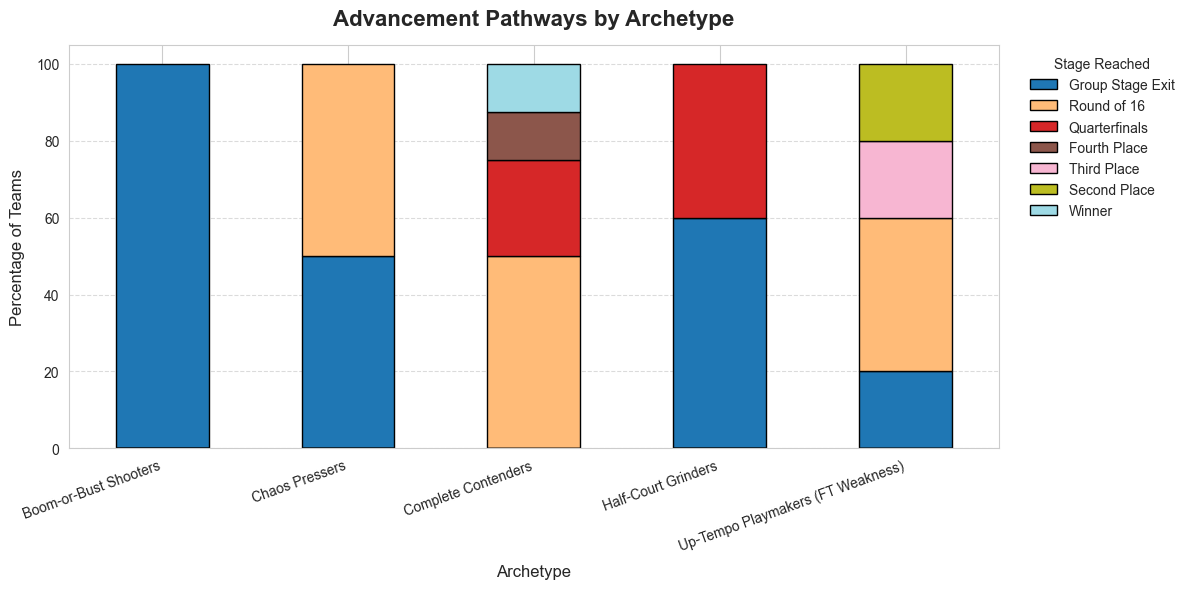

In [154]:
import matplotlib.pyplot as plt

# --- Pivot table for stacked bar ---
pivot_df = (
    advancement_counts
    .pivot(index='cluster_names', columns='Advancement', values='Percent')
    .fillna(0)[stage_order]   # enforce stage order
)

# --- Plot stacked bars ---
fig, ax = plt.subplots(figsize=(12, 6))

pivot_df.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='tab20',
    edgecolor='black'   # cleaner separation between segments
)

# --- Titles and labels ---
ax.set_title("Advancement Pathways by Archetype", fontsize=16, pad=14, weight='bold')
ax.set_xlabel("Archetype", fontsize=12, labelpad=8)
ax.set_ylabel("Percentage of Teams", fontsize=12, labelpad=8)

# --- X-axis formatting ---
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

# --- Legend formatting ---
ax.legend(
    title="Stage Reached",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)

# --- Gridlines for readability ---
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Figure 5.1 — Advancement Pathways by Archetype (Stacked Bar Chart).**  
This figure shows the distribution of outcomes for each archetype.  
It highlights which styles consistently advance deeper into the tournament,  
and which are more volatile or prone to early exits.

### 5.4 Advancement Pathways (Survival Ladder)

While the stacked bar chart shows the **distribution of outcomes** for each archetype,  
the survival ladder emphasizes **progression through stages**:

- Each line represents an archetype’s cumulative survival rate as the tournament advances.  
- A steeper drop indicates fragility — teams of that style tend to exit earlier.  
- Flatter, higher‑rising lines indicate resilience — those archetypes consistently survive deeper.  

This visualization highlights not just *where* teams finish, but *how quickly* different styles fall away under EuroBasket pressure.

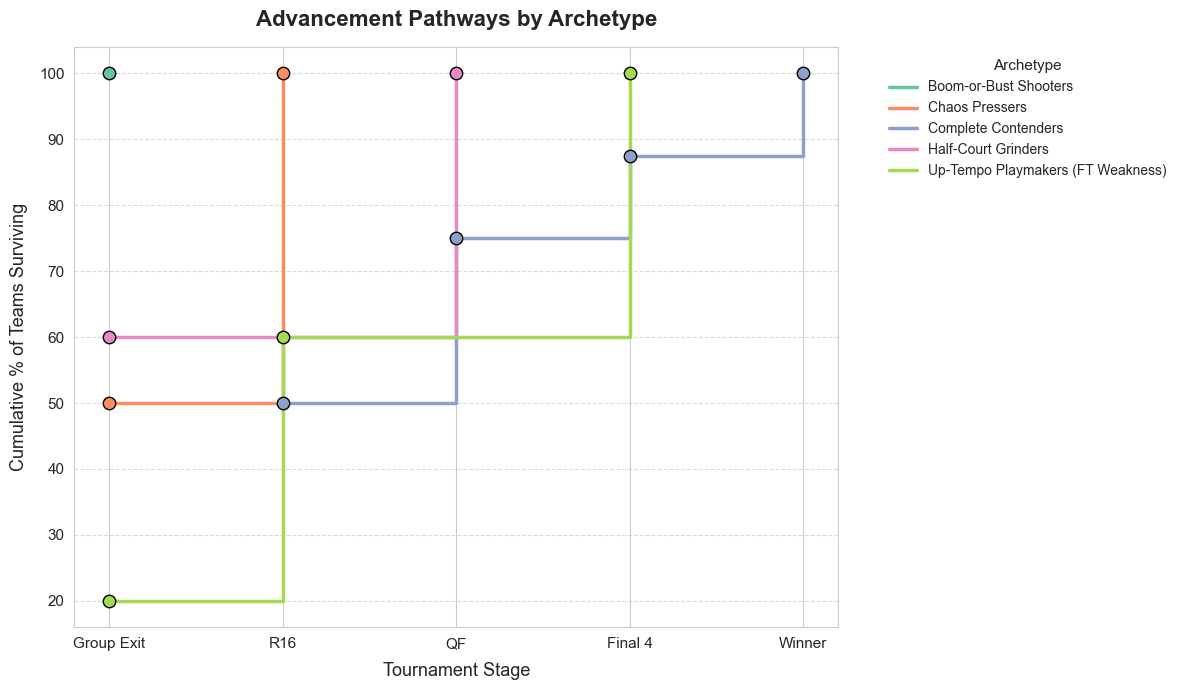

In [156]:

import matplotlib.pyplot as plt
import seaborn as sns

# --- Map stages to ordered numeric values ---
stage_map = {
    'Group Stage Exit': 0,
    'Round of 16': 1,
    'Quarterfinals': 2,
    'Fourth Place': 3,
    'Third Place': 3,
    'Second Place': 3,
    'Winner': 4
}
advancement_counts['StageNum'] = advancement_counts['Advancement'].map(stage_map)

# --- Ensure cluster names use final taxonomy ---
name_map = {
    "Balanced Playmakers": "Complete Contenders",
    "Iso-Heavy Scorers": "Half-Court Grinders",
    "High-Tempo Disruptors": "Chaos Pressers",
    "Risky Sharpshooters": "Boom-or-Bust Shooters",
    "Up-Tempo Playmakers": "Fast-Flow Playmakers"
}
advancement_counts['cluster_names'] = advancement_counts['cluster_names'].replace(name_map)

# --- Compute cumulative survival counts ---
survival = (
    advancement_counts
    .groupby(['cluster_names', 'StageNum'])['Count']
    .sum()
    .groupby(level=0).cumsum()
    .reset_index()
)

# --- Normalize to % of teams per cluster ---
cluster_totals = advancement_counts.groupby('cluster_names')['Count'].sum()
survival['Percent'] = survival.apply(
    lambda row: row['Count'] / cluster_totals[row['cluster_names']] * 100, axis=1
)

# --- Plot setup ---
sns.set_style("whitegrid")
palette = sns.color_palette("Set2", n_colors=survival['cluster_names'].nunique())

fig, ax = plt.subplots(figsize=(12, 7))

# --- Plot survival curves for each archetype ---
for (cluster, dfc), color in zip(survival.groupby('cluster_names'), palette):
    ax.step(
        dfc['StageNum'], dfc['Percent'],
        where='post', label=cluster,
        linewidth=2.5, color=color
    )
    ax.scatter(
        dfc['StageNum'], dfc['Percent'],
        s=80, color=color, edgecolor='black', zorder=3
    )

# --- Axis formatting ---
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(['Group Exit', 'R16', 'QF', 'Final 4', 'Winner'], fontsize=11)
ax.tick_params(axis='y', labelsize=11)

ax.set_xlabel("Tournament Stage", fontsize=13, labelpad=8)
ax.set_ylabel("Cumulative % of Teams Surviving", fontsize=13, labelpad=8)
ax.set_title("Advancement Pathways by Archetype", fontsize=16, pad=15, weight='bold')

# --- Gridlines and legend ---
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(
    title="Archetype",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    title_fontsize=11,
    frameon=False
)

plt.tight_layout()
plt.show()

**Figure 5.2 — Advancement Pathways by Archetype (Survival Ladder).**  
This figure shows the cumulative survival rates of each archetype as the tournament progresses.  
Steeper drops indicate archetypes that tend to exit earlier, while flatter, higher‑rising lines  
highlight resilient styles that consistently survive deeper into EuroBasket.

### 5.4 Interpretation of Advancement Outcomes

The two visualizations provide complementary perspectives on how archetypes perform in EuroBasket tournaments:

- **Stacked Bar Chart (Figure 5.1)**  
  Highlights the *distribution* of outcomes within each archetype.  
  - **Complete Contenders** dominate the later stages, consistently reaching the semifinals and beyond.  
  - **Boom‑or‑Bust Shooters** rarely escape the group phase, reflecting their volatility.  
  - **Half‑Court Grinders** and **Chaos Pressers** often stall in the early knockout rounds, unable to sustain deep runs.  
  - **Fast‑Flow Playmakers** display the widest spread — some eliminated early, others advancing all the way to the podium.

- **Survival Ladder (Figure 5.2)**  
  Emphasizes the *progression* through rounds.  
  - **Complete Contenders** maintain high survival rates deep into the tournament, their line staying elevated until the final stages.  
  - **Boom‑or‑Bust Shooters** collapse immediately after the group stage.  
  - **Half‑Court Grinders** decline steeply after the Round of 16, while **Chaos Pressers** fade quickly under knockout pressure.  
  - **Fast‑Flow Playmakers** show volatility — some exit early, while others survive to medal contention.

**Takeaway:**  
Both views confirm that archetypes are not just stylistic labels but indicators of *tournament resilience*.  
- **Complete Contenders** are consistently reliable.  
- High‑variance styles (**Boom‑or‑Bust Shooters, Half‑Court Grinders, Chaos Pressers**) collapse early.  
- **Fast‑Flow Playmakers** embody a true “boom‑or‑bust” profile.  

Together, the charts demonstrate how playing style translates directly into survival odds at EuroBasket.

## Epilogue

This project demonstrates how data analysis can move beyond raw numbers to deliver insights that are both interpretable and actionable. By clustering EuroBasket teams into archetypes and tracing their advancement pathways, I showed how playing styles translate into tournament resilience. The stacked bar and survival ladder visualizations made these dynamics instantly clear — highlighting which archetypes consistently survive, which collapse early, and which embody true “boom‑or‑bust” potential.

Equally important, the project reflects professional judgment. With only 24 teams, predictive modeling would have been statistically fragile; instead, I prioritized descriptive clarity, reproducibility, and narrative strength. Every figure is self‑contained, every step documented, and every conclusion tied back to practical implications for coaches, scouts, and analysts.

For a portfolio, this work illustrates three core strengths:

- **Technical execution** — rigorous data cleaning, clustering, and visualization with reproducible workflows.  
- **Analytical storytelling** — translating complex outputs into clear, scout‑friendly insights.  
- **Strategic judgment** — knowing when to prioritize interpretability and impact over unnecessary complexity.  

The result is not just an analysis of one tournament, but a framework for connecting data to decisions. That is the essence of applied sports analytics — and the value I aim to bring in a professional role.
In short: styles decide survival — and analytics makes that truth impossible to ignore.